In [1]:
# =============================
# Core libraries
# =============================
import numpy as np
import pandas as pd

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# Preprocessing
# =============================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# =============================
# Models
# =============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# =============================
# Evaluation
# =============================
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# =============================
# Utilities
# =============================
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('mpuData.xlsx')
data.head()

,Attempet_ID,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,1,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78
1,1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77
2,1,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75
3,1,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72
4,1,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Attempet_ID     628 non-null    int64  
 1   Movement_Name   628 non-null    object 
 2   Movement_Label  628 non-null    bool   
 3   Label_Value     628 non-null    int64  
 4   Joint_Label     628 non-null    object 
 5   Pitch           628 non-null    float64
 6   Roll            628 non-null    float64
 7   AccelX          628 non-null    float64
 8   AccelY          628 non-null    float64
 9   AccelZ          628 non-null    float64
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 44.9+ KB


In [4]:
# 1. Sort data to bring sequences of the same joint together
# This is crucial because the raw data alternates joints every row
data = data.sort_values(by=['Movement_Name', 'Joint_Label']).reset_index(drop=True)

# 2. Reconstruct Attempt ID based on Movement and Label continuity
# We don't trigger a change on Joint_Label to keep sequences long enough for windowing
data['Clean_Attempt_ID'] = (
    (data['Movement_Name'] != data['Movement_Name'].shift()) |
    (data['Label_Value'] != data['Label_Value'].shift())
).cumsum()

print(f"Total sequences identified: {data['Clean_Attempt_ID'].nunique()}")

Total sequences identified: 40


In [5]:
data[['Clean_Attempt_ID']].head(10)

,Clean_Attempt_ID
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,2
9,2


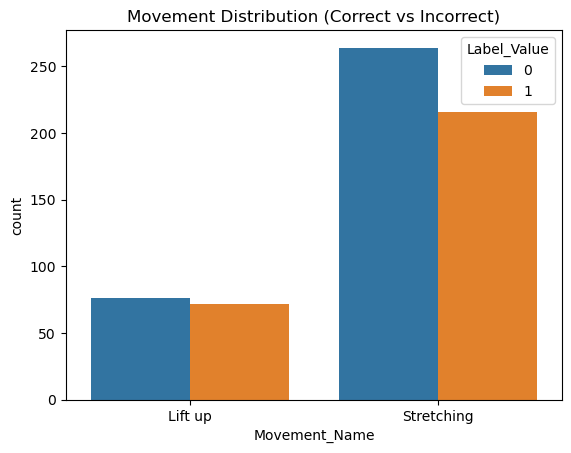

In [6]:
sns.countplot(x='Movement_Name', hue='Label_Value', data=data)
plt.title('Movement Distribution (Correct vs Incorrect)')
plt.show()

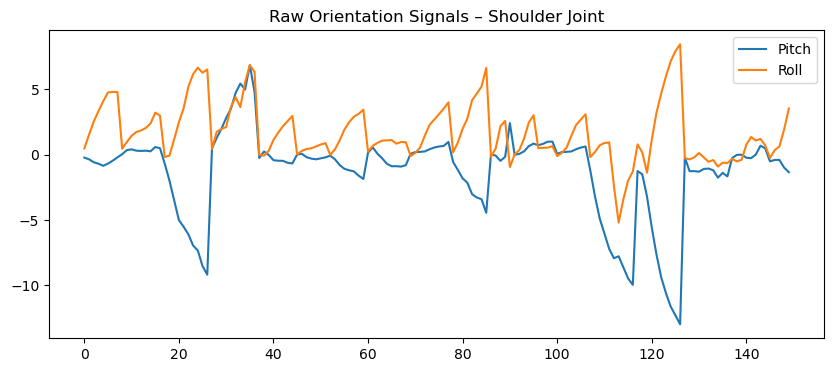

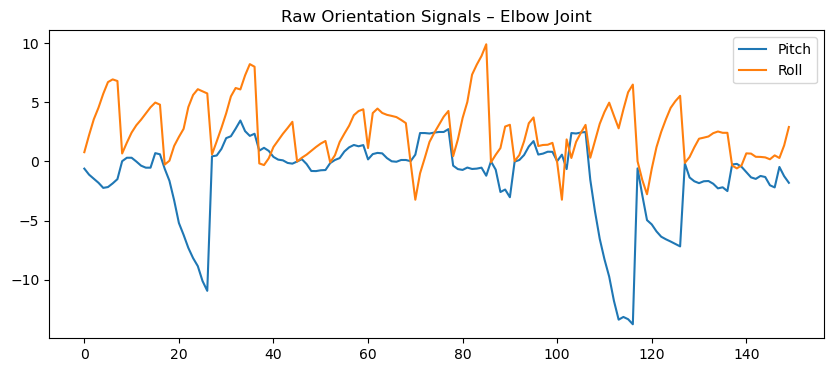

In [7]:
sample = data[data['Joint_Label'] == 'Shoulder'].iloc[:300]
plt.figure(figsize=(10,4))
plt.plot(sample['Pitch'].values[:150], label='Pitch')
plt.plot(sample['Roll'].values[:150], label='Roll')
plt.legend()
plt.title('Raw Orientation Signals – Shoulder Joint')
plt.show()
sample = data[data['Joint_Label'] == 'Elbow'].iloc[:300]
plt.figure(figsize=(10,4))
plt.plot(sample['Pitch'].values[:150], label='Pitch')
plt.plot(sample['Roll'].values[:150], label='Roll')
plt.legend()
plt.title('Raw Orientation Signals – Elbow Joint')
plt.show()

In [8]:
WINDOW_SIZE = 5  # Reduced slightly to ensure we capture enough windows from short movements
STEP = 2         # 50% overlap for data augmentation
sensor_cols = ['Pitch', 'Roll', 'AccelX', 'AccelY', 'AccelZ']

features = []
labels = []

# Grouping by Attempt and Joint to ensure temporal consistency
for (attempt_id, joint), group in data.groupby(['Clean_Attempt_ID', 'Joint_Label']):
    if len(group) < WINDOW_SIZE:
        continue

    for i in range(0, len(group) - WINDOW_SIZE + 1, STEP):
        window = group.iloc[i : i + WINDOW_SIZE]
        
        # Statistical aggregation
        feat = {}
        for col in sensor_cols:
            feat[f'{col}_mean'] = window[col].mean()
            feat[f'{col}_std']  = window[col].std()
            feat[f'{col}_max']  = window[col].max()
            feat[f'{col}_min']  = window[col].min()
        
        # Categorical context
        feat['Movement_Name'] = window['Movement_Name'].iloc[0]
        feat['Joint_Label'] = window['Joint_Label'].iloc[0]

        features.append(feat)
        labels.append(window['Label_Value'].iloc[0])

# Create the Final Feature Matrix
X = pd.DataFrame(features)
y = pd.DataFrame(labels)

print(f"Feature matrix generated: {X.shape}") # Should not be (0,0) now
X.head()

Feature matrix generated: (240, 22)


,Pitch_mean,Pitch_std,Pitch_max,Pitch_min,Roll_mean,Roll_std,Roll_max,Roll_min,AccelX_mean,AccelX_std,...,AccelY_mean,AccelY_std,AccelY_max,AccelY_min,AccelZ_mean,AccelZ_std,AccelZ_max,AccelZ_min,Movement_Name,Joint_Label
0,-1.448,0.626155,-0.61,-2.24,3.366,1.935298,5.72,0.78,1.664,0.029665,...,-0.440,0.050990,-0.39,-0.51,9.410,0.051478,9.48,9.37,Lift up,Elbow
1,-1.908,0.312842,-1.46,-2.24,5.496,1.436325,6.94,3.56,1.292,0.818120,...,-0.380,0.172916,-0.10,-0.57,9.452,0.094446,9.60,9.37,Lift up,Elbow
2,0.054,0.277363,0.31,-0.36,2.258,1.146983,3.53,0.67,1.152,0.024900,...,-0.060,0.090277,0.03,-0.18,10.262,0.013038,10.28,10.25,Lift up,Elbow
3,-0.224,0.366306,0.31,-0.53,3.532,0.833948,4.58,2.44,1.126,0.038471,...,-0.124,0.047223,-0.05,-0.18,10.272,0.008367,10.28,10.26,Lift up,Elbow
4,-0.024,0.620185,0.70,-0.53,4.388,0.593186,4.98,3.53,0.692,0.946636,...,-0.066,0.089051,0.05,-0.14,10.256,0.032094,10.28,10.20,Lift up,Elbow


In [9]:
y.head()

,0
0,1
1,1
2,0
3,0
4,0


In [10]:
# 1. One-Hot Encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['Movement_Name', 'Joint_Label'], drop_first=True)

# 2. Fill NaNs (std can be NaN if window values are identical)
X_encoded = X_encoded.fillna(0)

# 3. Splitting Data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Scaling (Crucial for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print("Data is ready for modeling.")

Data is ready for modeling.


In [11]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [13]:
ada = AdaBoostClassifier(n_estimators=300, random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=300, random_state=42)

In [14]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'AdaBoost': ada,
    'XGBoost': xgb
}

# =============================
# Automatic Best Model Selection
# =============================

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1': f1,
        'Model_Object': model
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1', ascending=False)

display(results_df[['Model', 'Accuracy', 'F1']])

# Select best model automatically
best_row = results_df.iloc[0]
best_model_name = best_row['Model']
best_model = best_row['Model_Object']

print(f"✅ Best model selected automatically: {best_model_name}")



,Model,Accuracy,F1
1,Random Forest,0.979167,0.975610
3,XGBoost,0.958333,0.950000
2,AdaBoost,0.895833,0.864865
0,Logistic Regression,0.708333,0.631579


✅ Best model selected automatically: Random Forest


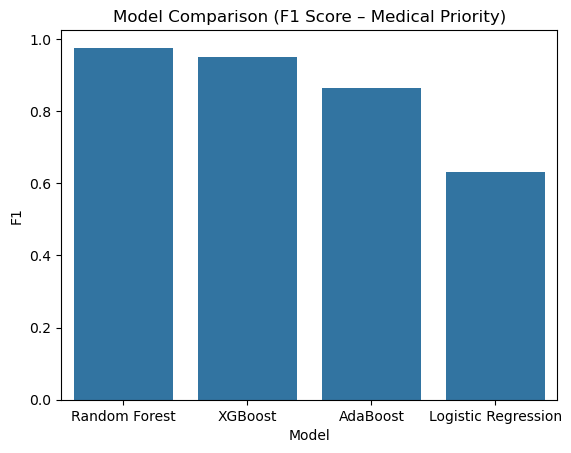

In [16]:
sns.barplot(x='Model', y='F1', data=results_df)
plt.title('Model Comparison (F1 Score – Medical Priority)')
plt.show()


🏆 Best Model Selected: Random Forest


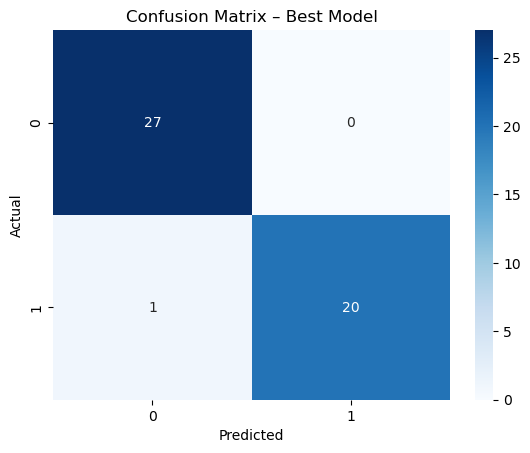

In [17]:
best_model_name = results_df.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

print(f"\n🏆 Best Model Selected: {best_model_name}")

cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
joblib.dump(best_model, 'best_mpu_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(X_encoded.columns.tolist(), 'feature_list.joblib')

['feature_list.joblib']